In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

## CIR Model

In [57]:
def funding_ratio(assets, liabilities, r):
    fr = pv(assets, r)/pv(liabilities, r)
    return fr.iloc[0]

#short rate vs annualized
def instant_to_annualized(r):
    return np.expm1(r)

def annualized_to_instant(r):
    return np.log1p(r)

In [69]:
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    if r_0 is None: r_0 = b 
    r_0 = annualized_to_instant(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=instant_to_annualized(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

<AxesSubplot:>

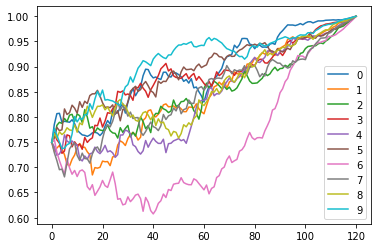

In [79]:
a_0 = .75
rates, bond_prices = cir(n_years=10, r_0=0.03, b = 0.03, n_scenarios = 10)
liability = bond_prices
bond_prices.plot()

# GHP Construction with Duration Matching

In [21]:
def discount(t, r):
    discounts = pd.DataFrame([(r+1)**-i for i in t])
    discounts.index = t
    return discounts

def pv(flows, r):
    dates = flows.index
    discounts = discount(dates, r)
    return discounts.multiply(flows, axis='rows').sum()

In [14]:
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):

    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupons = np.repeat(coupon_amt, n_coupons)
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal
    return cash_flows

In [85]:
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    if isinstance(discount_rate, pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.loc[t] = bond_price(maturity-t/coupons_per_year, principal, coupon_rate, coupons_per_year,
                                      discount_rate.loc[t])
        return prices
    else: # base case ... single time period
        if maturity <= 0: return principal+principal*coupon_rate/coupons_per_year
        cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
        return pv(cash_flows, discount_rate/coupons_per_year)

In [32]:
bond_price(20, 1000, 0.05, 2, 0.04)

1136.7773962036904

In [27]:
rates = np.linspace(.01, .10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [33]:
prices = [bond_price(10, 1000, .05, 2, rate) for rate in rates]
prices

[1379.7483829333992,
 1326.7629283179222,
 1276.1632981372743,
 1227.833537616068,
 1181.6636507727876,
 1137.5492793724407,
 1095.3913999300185,
 1055.0960377089511,
 1016.5739967228162,
 979.7406048086303,
 944.5154728963505,
 910.8222676519945,
 878.5884967212596,
 847.74530584692,
 818.2272871767957,
 789.9722981198867,
 762.9212901465673,
 737.0181469646424,
 712.209531536784,
 688.4447414365]

<AxesSubplot:>

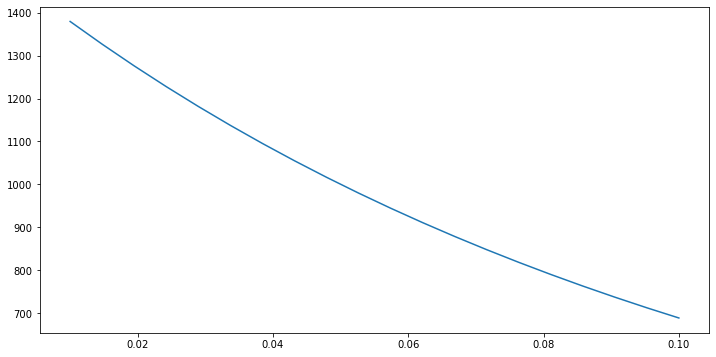

In [35]:
pd.DataFrame(data=prices, index=rates).plot(legend=False, figsize=(12,6))

In [36]:
def macaulay_duration(flows, discount_rate):
    discounted_flows = discount(flows.index, discount_rate)*pd.DataFrame(flows)
    weights = discounted_flows/discounted_flows.sum()
    return np.average(flows.index, weights=weights.iloc[:,0])

In [37]:
macaulay_duration(bond_cash_flows(3, 1000, 0.06, 2), 0.03)

5.579707187194534

# Duration Matching

In [46]:
liabilities = pd.Series(data=[100000, 100000], index=[10,12])
macaulay_duration(liabilities, 0.04)

10.960799385088393

In [42]:
md_10 = macaulay_duration(bond_cash_flows(10, 1000, .05, 1), .04)
md_20 = macaulay_duration(bond_cash_flows(20, 1000, .05, 1), .04)

In [43]:
md_10, md_20

(8.190898824083233, 13.544718122145921)

In [44]:
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)

In [52]:
short_bond = bond_cash_flows(10, 1000, 0.05, 1)
long_bond = bond_cash_flows(20, 1000, 0.05, 1)
weight = match_durations(liabilities, short_bond, long_bond, 0.04)

In [58]:
price_short = bond_price(10, 1000, .05, 1, .04)
price_long = bond_price(20, 1000, .05, 1, .04)
a_0 = 130000
p_flow = pd.concat([a_0*weight*short_bond/price_short,a_0*(1-weight)*long_bond/price_long])
cfr = funding_ratio(p_flow, liabilities, .04)
cfr

0.9998760012192478

<AxesSubplot:title={'center':'Funding Ratios vs Change in interest rates'}>

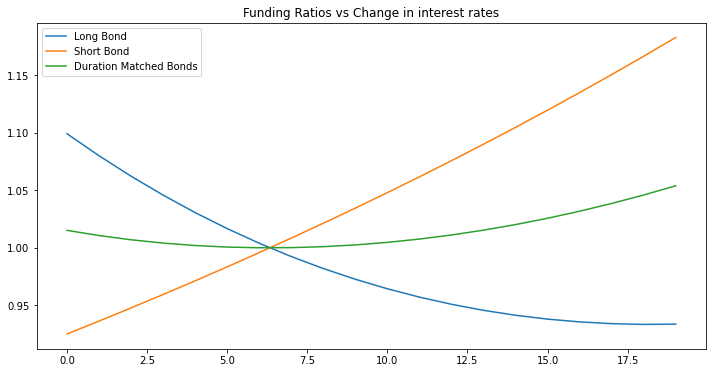

In [60]:
fr_change = pd.DataFrame({
    "Long Bond": [funding_ratio(a_0*long_bond/price_long, liabilities, r) for r in rates],
    "Short Bond": [funding_ratio(a_0*short_bond/price_short, liabilities, r) for r in rates],
    "Duration Matched Bonds": [funding_ratio(p_flow, liabilities, r) for r in rates]
})

fr_change.plot(title="Funding Ratios vs Change in interest rates", figsize=(12,6))

# Simulation of Price of Coupon Bearing Bond using CIR

In [61]:
bond_price(5, 100, .05, 12, .03)

109.27539294780118

In [81]:
rate, zc_prices = cir(10, 500, b=0.03, r_0=0.03)

In [86]:
bond_price(5, 100, .05, 12, rate.iloc[0][[1,2,3]])

1    109.275393
2    109.275393
3    109.275393
dtype: float64

<AxesSubplot:>

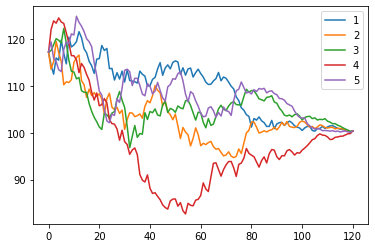

In [87]:
bond_price(10, 100, .05, 12, rate[[1,2,3,4,5]]).plot()

In [88]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

In [94]:
price = bond_price(10, 100, .05, 12, rate[[1,2,3,4]])
price

,1,2,3,4
0,117.260292,117.260292,117.260292,117.260292
1,114.4377,113.599606,117.573527,122.087488
2,112.541061,115.254535,118.844307,123.931643
3,116.004128,119.533124,120.130164,123.433103
4,115.52771,117.180113,119.791477,124.563436
...,...,...,...,...
116,100.719115,100.849265,101.10119,99.301649
117,100.533051,100.612574,100.829291,99.545442
118,100.468135,100.436584,100.587598,99.799789
119,100.271467,100.231234,100.307329,99.847564


In [92]:
bond_returns = price.pct_change().dropna()
annualize_rets(bond_returns, 12)

1   -0.015387
2   -0.015387
3   -0.015387
4   -0.015387
5   -0.015387
dtype: float64

In [93]:
def bond_total_return(monthly_prices, principal, coupon_rate, coupons_per_year):

    coupons = pd.DataFrame(data = 0, index=monthly_prices.index, columns=monthly_prices.columns)
    t_max = monthly_prices.index.max()
    pay_date = np.linspace(12/coupons_per_year, t_max, int(coupons_per_year*t_max/12), dtype=int)
    coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
    total_returns = (monthly_prices + coupons)/monthly_prices.shift()-1
    return total_returns.dropna()

In [95]:
btr = bond_total_return(price, 100, .05, 12)
annualize_rets(btr, 12)

1    0.030828
2    0.033503
3    0.032363
4    0.036754
dtype: object

In [96]:
price_10 = bond_price(10, 100, .05, 12, rate)
price_10[[1,2,3]].tail()

,1,2,3
116,100.719115,100.849265,101.10119
117,100.533051,100.612574,100.829291
118,100.468135,100.436584,100.587598
119,100.271467,100.231234,100.307329
120,100.416667,100.416667,100.416667


In [97]:
price_30 = bond_price(30, 100, .05, 12, rate)
price_30[[1,2,3]].tail()

,1,2,3
116,133.52203,141.018287,157.041439
117,132.909692,138.926235,157.099628
118,145.910339,142.076159,161.621935
119,155.274068,145.011752,165.176574
120,152.002731,144.287862,163.122604


In [111]:
rets_10 = bond_total_return(price_10, 100, .05, 12)
rets_30 = bond_total_return(price_30, 100, .05, 12)
rets_bonds = .6*rets_10 + .4*rets_30
rets_bonds

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1,0.029487,-0.031307,-0.041631,0.008052,0.066796,0.032179,0.004789,-0.003936,0.050265,-0.010543,...,0.061681,0.02306,0.012195,0.018813,0.000152,-0.001322,0.000923,-0.032393,0.035098,-0.013993
2,-0.008227,-0.020238,0.025744,0.020348,0.027232,-0.039152,-0.007433,-0.02703,-0.036641,0.012607,...,-0.033125,0.033619,-0.033418,0.030381,0.029752,0.015988,-0.021114,0.008401,0.05378,0.009014
3,-0.004256,0.05026,0.06055,0.020512,-0.002011,-0.005716,-0.043966,0.040172,-0.012433,-0.021779,...,-0.045586,-0.023252,-0.02129,0.006068,0.013132,0.027672,-0.015686,-0.012859,0.080472,0.033051
4,0.025515,-0.002046,-0.025403,-0.000157,0.018285,-0.017781,0.068835,0.019606,-0.004585,-0.020738,...,-0.036809,-0.004867,0.033808,-0.022962,0.064339,0.014726,-0.027853,0.014795,-0.005349,-0.003247
5,0.033687,0.061153,-0.020092,-0.003268,-0.006564,-0.001426,0.029462,-0.015077,0.0157,0.017287,...,0.023598,0.033959,0.0792,-0.015043,0.018131,-0.009043,0.049458,-0.000639,0.016432,-0.008685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,-0.004993,0.019059,0.023294,-0.005594,-0.011295,0.032514,-0.018477,0.005307,-0.001462,-0.008811,...,-0.002361,-0.002209,-0.030177,-0.016527,-0.006232,0.002605,0.000561,-0.002459,-0.016317,0.001807
117,0.010632,0.000788,-0.003681,0.002069,0.019981,0.039977,-0.019447,-0.013456,0.012469,0.017762,...,-0.009849,-0.001462,0.006717,-0.026006,-0.005769,-0.00157,0.013549,-0.003761,0.002423,-0.016774
118,-0.006688,0.04248,0.011704,0.013617,0.037322,-0.01468,0.011679,0.004873,0.005645,-0.004805,...,-0.017118,-0.016681,0.006439,0.009239,-0.002773,0.00916,-0.008959,0.009657,-0.011319,0.017564
119,-0.010161,0.028126,0.0107,0.010642,-0.023876,0.002148,-0.001105,0.025774,0.001078,0.020022,...,0.00522,-0.009359,-0.010269,-0.010589,0.006625,0.002305,0.006472,-0.003914,0.004054,0.009217


In [100]:
mean_rets_bonds = rets_bonds.mean(axis='columns')
mean_rets_bonds

1      0.003485
2      0.004184
3      0.005945
4      0.003415
5      0.006373
         ...   
116    0.003372
117    0.003510
118    0.002978
119    0.002616
120    0.005268
Length: 120, dtype: float64

In [107]:
def gbm(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0, prices=True):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices through Monte Carlo
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    # the standard way ...
    # rets_plus_1 = np.random.normal(loc=mu*dt+1, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    # without discretization error ...
    rets_plus_1 = np.random.normal(loc=(1+mu)**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    ret_val = s_0*pd.DataFrame(rets_plus_1).cumprod() if prices else rets_plus_1-1
    return ret_val

In [102]:
price_eq = gbm(10, 500, 0.07, 0.15)

In [103]:
rets_eq = price_eq.pct_change().dropna()

In [104]:
rets = 7*rets_eq + 3*rets_bonds
rets_mean = rets.mean(axis='columns')

# Naive Risk Budgeting Strategies PSP vs GHP

In [109]:
def bt_mix(r1, r2, allocator, **kwargs):
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [110]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)

In [116]:
rets_bonds = bt_mix(rets_10, rets_30, allocator=fixedmix_allocator, w1=.6)
mean_rets_bond = rets_bonds.mean(axis='columns')
mean_rets_bond

1      0.003485
2      0.004184
3      0.005945
4      0.003415
5      0.006373
         ...   
116    0.003372
117    0.003510
118    0.002978
119    0.002616
120    0.005268
Length: 120, dtype: float64

In [114]:
rets_bonds

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1,0.029487,-0.031307,-0.041631,0.008052,0.066796,0.032179,0.004789,-0.003936,0.050265,-0.010543,...,0.061681,0.02306,0.012195,0.018813,0.000152,-0.001322,0.000923,-0.032393,0.035098,-0.013993
2,-0.008227,-0.020238,0.025744,0.020348,0.027232,-0.039152,-0.007433,-0.02703,-0.036641,0.012607,...,-0.033125,0.033619,-0.033418,0.030381,0.029752,0.015988,-0.021114,0.008401,0.05378,0.009014
3,-0.004256,0.05026,0.06055,0.020512,-0.002011,-0.005716,-0.043966,0.040172,-0.012433,-0.021779,...,-0.045586,-0.023252,-0.02129,0.006068,0.013132,0.027672,-0.015686,-0.012859,0.080472,0.033051
4,0.025515,-0.002046,-0.025403,-0.000157,0.018285,-0.017781,0.068835,0.019606,-0.004585,-0.020738,...,-0.036809,-0.004867,0.033808,-0.022962,0.064339,0.014726,-0.027853,0.014795,-0.005349,-0.003247
5,0.033687,0.061153,-0.020092,-0.003268,-0.006564,-0.001426,0.029462,-0.015077,0.0157,0.017287,...,0.023598,0.033959,0.0792,-0.015043,0.018131,-0.009043,0.049458,-0.000639,0.016432,-0.008685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,-0.004993,0.019059,0.023294,-0.005594,-0.011295,0.032514,-0.018477,0.005307,-0.001462,-0.008811,...,-0.002361,-0.002209,-0.030177,-0.016527,-0.006232,0.002605,0.000561,-0.002459,-0.016317,0.001807
117,0.010632,0.000788,-0.003681,0.002069,0.019981,0.039977,-0.019447,-0.013456,0.012469,0.017762,...,-0.009849,-0.001462,0.006717,-0.026006,-0.005769,-0.00157,0.013549,-0.003761,0.002423,-0.016774
118,-0.006688,0.04248,0.011704,0.013617,0.037322,-0.01468,0.011679,0.004873,0.005645,-0.004805,...,-0.017118,-0.016681,0.006439,0.009239,-0.002773,0.00916,-0.008959,0.009657,-0.011319,0.017564
119,-0.010161,0.028126,0.0107,0.010642,-0.023876,0.002148,-0.001105,0.025774,0.001078,0.020022,...,0.00522,-0.009359,-0.010269,-0.010589,0.006625,0.002305,0.006472,-0.003914,0.004054,0.009217


In [118]:
rets_7030b = bt_mix(rets_eq, rets_bonds, 
                    allocator = fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis=1)
rets_7030b_mean

1      0.006642
2      0.003730
3      0.007796
4      0.007130
5      0.003929
         ...   
116    0.005057
117    0.005175
118    0.006082
119    0.003708
120    0.006203
Length: 120, dtype: float64

In [119]:
def terminal_values(rets):
    return (rets+1).prod()

In [120]:
def terminal_stats(rets, floor = 0.8, cap=np.inf, name="Stats"):
    """
    Produce Summary Statistics on the terminal values per invested dollar
    across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column DataFrame of Summary Stats indexed by the stat name 
    """
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = reach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (-cap+terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std" : terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short":e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats

In [121]:
pd.concat([
    terminal_stats(rets_bonds, name = 'FI'),
    terminal_stats(rets_eq, name = "Eq"),
    terminal_stats(rets_7030b, name = '70/30')
], axis=1)

,FI,Eq,70/30
mean,1.387069,2.007604,1.805560
std,0.106602,1.061148,0.636648
p_breach,NaN,0.040000,0.012000
e_short,NaN,0.134592,0.080277
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


# Glide Paths for Allocation

In [122]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data = np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [124]:
rets_g8020 = bt_mix(rets_eq, rets_bonds, allocator=glidepath_allocator, 
                    start_glide=.8, end_glide=.2)
pd.concat([
    terminal_stats(rets_bonds, name = 'FI'),
    terminal_stats(rets_eq, name = "Eq"),
    terminal_stats(rets_7030b, name = '70/30'),
    terminal_stats(rets_g8020, name = 'Glide 80 to 20')
], axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.387069,2.007604,1.805560,1.678964
std,0.106602,1.061148,0.636648,0.445569
p_breach,NaN,0.040000,0.012000,0.004000
e_short,NaN,0.134592,0.080277,0.032375
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


# Dynamic Risk Budgeting

In [126]:
n_scenarios = 5000
rates, zc_prices = cir(10, n_scenarios=n_scenarios, b=.03, r_0=.03, sigma=.02)
price_eq = gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [129]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = bt_mix(rets_eq, rets_zc, 
                    allocator = fixedmix_allocator, w1=0.7)
pd.concat([
    terminal_stats(rets_zc, name = 'ZC', floor=0.75),
    terminal_stats(rets_eq, name = "Eq", floor=0.75),
    terminal_stats(rets_7030b, name = '70/30', floor=0.75)
], axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.96,1.75
std,0.00,0.98,0.59
p_breach,NaN,0.04,0.01
e_short,NaN,0.11,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [130]:
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC Prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ## PV of Floor assuming today's rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

In [135]:
rets_floor75 = bt_mix(rets_eq, rets_zc, 
                    allocator = floor_allocator, floor = .75, zc_prices=zc_prices[1:])
pd.concat([
    terminal_stats(rets_zc, name = 'ZC', floor=0.75),
    terminal_stats(rets_eq, name = "Eq", floor=0.75),
    terminal_stats(rets_7030b, name = '70/30', floor=0.75),
    terminal_stats(rets_floor75, name = 'Floor', floor=0.75)
], axis=1).round(2)

,ZC,Eq,70/30,Floor
mean,1.34,1.96,1.75,1.93
std,0.00,0.98,0.59,0.98
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.11,0.08,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [145]:
rets_floor75m1 = bt_mix(rets_eq, rets_zc, 
                    allocator = floor_allocator, floor = .75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = bt_mix(rets_eq, rets_zc, 
                    allocator = floor_allocator, floor = .75, zc_prices=zc_prices[1:], m=5)
rets_floor75 = bt_mix(rets_eq, rets_zc, 
                    allocator = floor_allocator, floor = .75, zc_prices=zc_prices[1:])
pd.concat([
    terminal_stats(rets_zc, name = 'ZC', floor=0.75),
    terminal_stats(rets_eq, name = "Eq", floor=0.75),
    terminal_stats(rets_7030b, name = '70/30', floor=0.75),
    terminal_stats(rets_floor75, name = 'Floor', floor=0.75),
    terminal_stats(rets_floor75m1, name = 'FloorM1', floor=0.75),
    terminal_stats(rets_floor75m5, name = 'FloorM5', floor=0.75)
], axis=1).round(4)

,ZC,Eq,70/30,Floor,FloorM1,FloorM5
mean,1.3433,1.9552,1.7481,1.9320,1.6154,1.9417
std,0.0000,0.9757,0.5917,0.9811,0.4306,0.9837
p_breach,NaN,0.0376,0.0064,NaN,NaN,0.0002
e_short,NaN,0.1067,0.0796,NaN,NaN,0.0001
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
def drawdown_allocator(psp_r, ghp_r, maxdd, m=3):
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    peak_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = (1-maxdd)*peak_value ### Floor is based on Prev Peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value and prev peak at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        peak_value = np.maximum(peak_value, account_value)
        w_history.iloc[step] = psp_w
    return w_history

In [146]:
cashrate = 0.2
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data = monthly_cashreturn, index = rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = bt_mix(rets_eq, rets_cash, 
                    allocator = drawdown_allocator, maxdd=.25)
pd.concat([
    terminal_stats(rets_zc, name = 'ZC', floor=0.75),
    terminal_stats(rets_eq, name = "Eq", floor=0.75),
    terminal_stats(rets_7030b, name = '70/30', floor=0.75),
    terminal_stats(rets_floor75, name = 'Floor', floor=0.75),
    terminal_stats(rets_floor75m1, name = 'FloorM1', floor=0.75),
    terminal_stats(rets_floor75m5, name = 'FloorM5', floor=0.75),
    terminal_stats(rets_maxdd25, name = 'maxdd25', floor=0.75)
], axis=1).round(4)

,ZC,Eq,70/30,Floor,FloorM1,FloorM5,maxdd25
mean,1.3433,1.9552,1.7481,1.9320,1.6154,1.9417,2.8179
std,0.0000,0.9757,0.5917,0.9811,0.4306,0.9837,0.8831
p_breach,NaN,0.0376,0.0064,NaN,NaN,0.0002,NaN
e_short,NaN,0.1067,0.0796,NaN,NaN,0.0001,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
def get_ind_file(filetype):
    """
    Load and format the Ken French 30 Industry Portfolios files
    """
    known_types = ["returns", "nfirms", "size"]
    if filetype not in known_types:
        sep = ','
        raise ValueError(f'filetype must be one of:{sep.join(known_types)}')
    if filetype is "returns":
        name = "vw_rets"
        divisor = 100
    elif filetype is "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype is "size":
        name = "size"
        divisor = 1
    ind = pd.read_csv(f"data/ind30_m_{name}.csv", header=0, index_col=0)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_returns():
    """
    Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns
    """
    return get_ind_file("returns")

def get_ind_nfirms():
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms")

def get_ind_size():
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size")

def get_total_market_index_returns():
    """
    Load the 30 industry portfolio data and derive the returns of a capweighted total market index
    """
    ind_nfirms = get_ind_nfirms()
    ind_size = get_ind_size()
    ind_return = get_ind_returns()
    ind_mktcap = ind_nfirms * ind_size
    total_mktcap = ind_mktcap.sum(axis=1)
    ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    return total_market_return

<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-147-cf675ecff591>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if filetype is "returns":
<ipython-input-147-cf675ecff591>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "nfirms":
<ipython-input-147-cf675ecff591>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "size":


In [149]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

<AxesSubplot:>

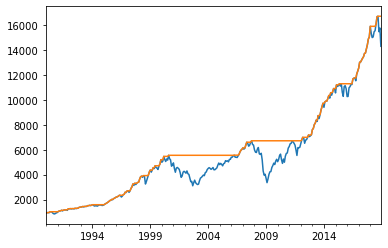

In [150]:
rets_tmi = get_total_market_index_returns()["1990":]
dd_tmi = drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot()
dd_tmi["Previous Peak"].plot(ax=ax)

In [154]:
b1 = bond_price(15, 1000, .05, 2, .05)
b2 = bond_price(5, 1000, .06, 4, .05)
b3 = bond_price(10, 1000, 0, 1, .05)
b1, b2, b3

(0    1000.0
 dtype: float64,
 0    1043.99829
 dtype: float64,
 0    613.913254
 dtype: float64)

In [155]:
cf_b1 = bond_cash_flows(15, 1000, .05, 2)
cf_b2 = bond_cash_flows(5, 1000, .06, 4)
cf_b3 = bond_cash_flows(10, 1000, 0, 1)

In [156]:
db1 = macaulay_duration(cf_b1, .05/2)/2
db2 = macaulay_duration(cf_b2, .05/4)/4
db3 = macaulay_duration(cf_b3, .05)
db1, db2, db3

(10.72677495379012, 4.373363222636413, 10.0)

In [161]:
liabilities = pd.Series([100000,200000,300000],index=[3,5,10])

In [158]:
dl = macaulay_duration(liabilities, .05)
dl

6.750917852744651

In [163]:
def match_durations_mod(cf_t, cf_s, cf_l, discount_rate):
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate/4)/4
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)

In [164]:
match_durations_mod(liabilities, cf_b2, cf_b3, .05)

0.5774465770256697

In [ ]:
def match_durations_mod2(cf_t, cf_s, cf_l, discount_rate):
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)